<a href="https://www.kaggle.com/code/arijeetpramanik/regularized-logistic-regression-from-scratch?scriptVersionId=123296132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import jax.numpy as jnp # linear algebra
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
from PIL import ImageShow
import jax
import random
import matplotlib.pyplot as plt

## Predefining some variables
* Here we will be resizing images in 150x150 pixel format
* **Note:** Turn on your GPU Accelerator from more options (JAX uses GPU to speed up calculations)
* **Recommended to use:** GPU P100

In [2]:
CATS_TRAINING_PATH = '/kaggle/input/dogs-cats-images/dataset/training_set/cats'
DOGS_TRAINING_PATH = '/kaggle/input/dogs-cats-images/dataset/training_set/dogs'
CATS_TEST_PATH = '/kaggle/input/dogs-cats-images/dataset/test_set/cats'
DOGS_TEST_PATH = '/kaggle/input/dogs-cats-images/dataset/test_set/dogs'

IMG_WIDTH = 150
IMG_HEIGHT = 150
PIXELS = IMG_WIDTH*IMG_HEIGHT
RGB = 3
N = PIXELS*RGB

## Creating a Function for loading data
This Function will be used in forming the dataset

In [3]:
def create_image_dataset(path):
    data = []
    for file in os.listdir(path):
        image_path = os.path.join(path, file)
        image = Image.open(image_path).resize((IMG_HEIGHT,IMG_WIDTH))
        image_array = jnp.asarray(image,)
        data.append(image_array)
    return jnp.array(data)

## Data PreProcessing

Training Set

In [4]:
%%time

cat_train_set = create_image_dataset(CATS_TRAINING_PATH)
dogs_train_set = create_image_dataset(DOGS_TRAINING_PATH)

CPU times: user 40.5 s, sys: 2.46 s, total: 43 s
Wall time: 1min 58s


In [5]:
m_train = len(cat_train_set) + len(dogs_train_set)
y_label_cat = jnp.zeros((len(cat_train_set), 1))
y_label_dog = jnp.ones((len(dogs_train_set), 1))

X_train = jnp.concatenate((cat_train_set, dogs_train_set), axis = 0)
Y_train = jnp.concatenate((y_label_cat, y_label_dog), axis =0)

#### Shuffling the training data

In [6]:
temp = list(zip(X_train ,Y_train))
random.shuffle(temp)
X_train,Y_train = zip(*temp)

X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)

## Data PreProcessing
Test and CV data

In [7]:
%%time
cat_test_set = create_image_dataset(CATS_TEST_PATH)
dogs_test_set = create_image_dataset(DOGS_TEST_PATH)

CPU times: user 10.1 s, sys: 505 ms, total: 10.6 s
Wall time: 25.3 s


In [8]:
y_label_cat = jnp.zeros((len(cat_test_set), 1))
y_label_dog = jnp.ones((len(dogs_test_set), 1))

X_test = jnp.concatenate((cat_test_set, dogs_test_set), axis = 0)
Y_test = jnp.concatenate((y_label_cat, y_label_dog), axis = 0)

m_test = len(X_test)

#### Shuffling the test data and splitting into CV and test equally

In [9]:
temp = list(zip(X_test ,Y_test))
random.shuffle(temp)
X_test,Y_test = zip(*temp)
X_test, Y_test = jnp.array(X_test), jnp.array(Y_test)

#m_test = m_dummy//2
#m_cv = m_dummy - m_test
#X_test, Y_test = jnp.array(X_dummy[:m_test]), jnp.array(Y_dummy[:m_test])
#X_cv, Y_cv = jnp.array(X_dummy[m_test:]), jnp.array(Y_dummy[m_test:])

#### Reshaping into 2D Matrix of dimensions (N x m)

In [10]:
X_train = X_train.reshape((m_train, N)).T
X_test = X_test.reshape((m_test, N)).T
#X_cv = X_cv.reshape((m_cv, N)).T

In [11]:
print("#Features:",N)
print("#Training Examples:", m_train)
#print("#Cross-Validation Examples:",m_cv)
print("#Test Examples:", m_test)

#Features: 67500
#Training Examples: 8000
#Test Examples: 2000


#### Showing Samples before Training the data

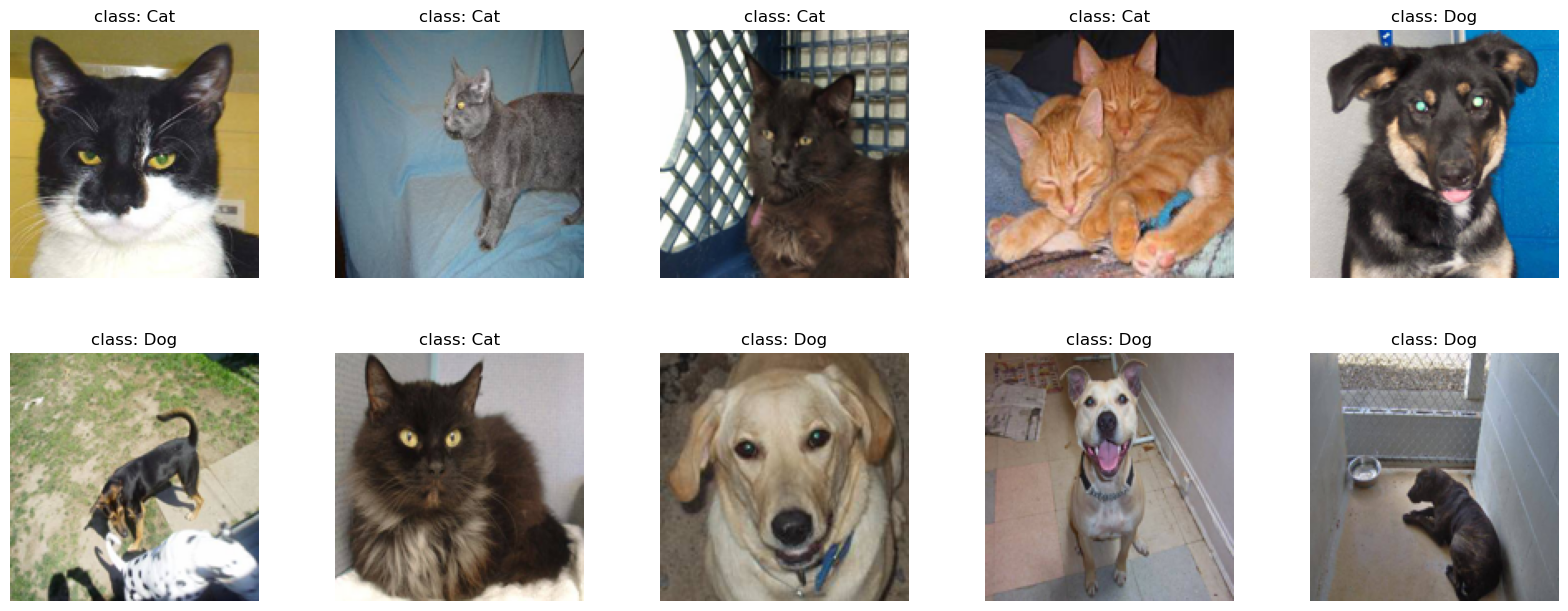

In [12]:
labels = ['Cat','Dog']
samples = X_train.T[:10]
tags = Y_train[:10]
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace = 0.3)
    plt.imshow(samples[i].reshape((IMG_HEIGHT, IMG_WIDTH, RGB)))
    plt.title(f"class: {labels[int(tags[i])]}")
    plt.axis('off')

## Training Data with Gradient Descent
Creating Necessary functions for the training

In [13]:
def sigmoid(Z):
    return 1/(1+jnp.exp(-Z))

In [14]:
def compute_cost_and_gradients(W, b, X, Y, lambd):
    n, m = X.shape
    J, b_gradient = 0, 0
    W_gradients = jnp.zeros((n, 1))
    
    h = sigmoid((W.T).dot(X) + b)
    #print(W, b)
    #print(h)
    J = -((jnp.nan_to_num(jnp.log(h))).dot(Y) + (jnp.nan_to_num(jnp.log(1-h))).dot(1-Y)).reshape(1)
    J += lambd*(jnp.sum(W**2))
    J = J/m
    ##print(J)
    
    W_gradients = X.dot(h.T-Y) + lambd*W
    W_gradients /= m
    
    b_gradient = jnp.sum(h.T-Y)/m
    
    return J[0], W_gradients, b_gradient

In [15]:
def predict(W, b, X):
    h = sigmoid((W.T).dot(X) + b)
    Y_predict = (h>=0.5)*1.0
    return Y_predict.T

#### Initializaton

In [16]:
W = jnp.zeros((N, 1))
b = 0

In [17]:
def gradient_descent(X, Y, W, b, alpha, lambd, num_iterations = 15000):
    J_stats = []
    iterations = jnp.arange(0, num_iterations, 10)
    for i in range(num_iterations):
        ##A = sigmoid((W.T).dot(X) + b)
        J, W_gradients, b_gradient = compute_cost_and_gradients(W, b, X, Y, lambd)
        if (i+1)%1000 == 0:
            print(f"Cost Function at iteration {i+1}:", J)
        if (i+1)%10 == 0:
            J_stats.append(J)
        W = W - alpha*W_gradients
        b = b - alpha*b_gradient
        
    plt.plot(iterations[:], J_stats[:])
    plt.xlabel("Iterations")
    plt.ylabel("Cost Function")
    plt.show()

    return W, b

In [18]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

Cost Function at iteration 1000: 0.64688957
Cost Function at iteration 2000: 0.6333017
Cost Function at iteration 3000: 0.6229314
Cost Function at iteration 4000: 0.6143787
Cost Function at iteration 5000: 0.6070348
Cost Function at iteration 6000: 0.60055226
Cost Function at iteration 7000: 0.59471345
Cost Function at iteration 8000: 0.5893739
Cost Function at iteration 9000: 0.5844332
Cost Function at iteration 10000: 0.5798194
Cost Function at iteration 11000: 0.5754788
Cost Function at iteration 12000: 0.5713708
Cost Function at iteration 13000: 0.5674639
Cost Function at iteration 14000: 0.56373304
Cost Function at iteration 15000: 0.56015813


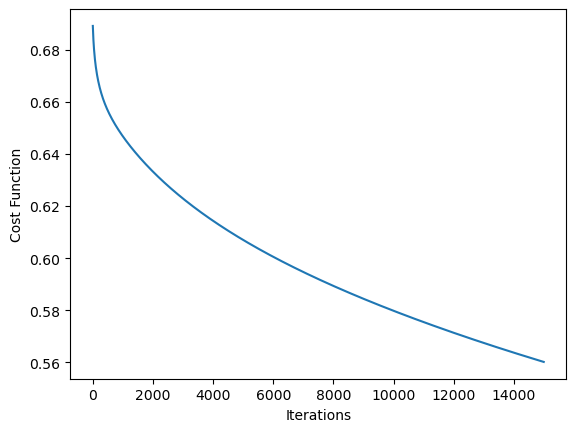

CPU times: user 1min 14s, sys: 7.74 s, total: 1min 22s
Wall time: 2min 45s


In [19]:
%%time

W, b = gradient_descent(X_train, Y_train, W, b, 0.000000007, 0.1)

### Training Set Accuracy

In [20]:
Y_predict = predict(W, b, X_train)
correct = jnp.sum((Y_predict==Y_train)*1.0)
Accuracy = correct/m_train
print("Training Accuracy:",Accuracy)

Training Accuracy: 0.73175


In [21]:
Y_predict = predict(W, b, X_test)
correct = jnp.sum((Y_predict==Y_test)*1.0)
Accuracy = correct/m_test
print("Test Accuracy:", Accuracy)

Test Accuracy: 0.60200006
